In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


Data read.


In [2]:
!pip install split-folders
# /kaggle/input/train-test/combined
import splitfolders
splitfolders.ratio('C:/Users/vinay/OneDrive/Documents/Projects/Medical/alzheimers_prediction/combined_org', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [00:16, 398.89 files/s]


In [3]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(176, 176),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(176, 176),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(176, 176),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [34]:
class_names = ['MildDemented',
          'ModerateDemented',
           'NonDemented',
          'VeryMildDemented']

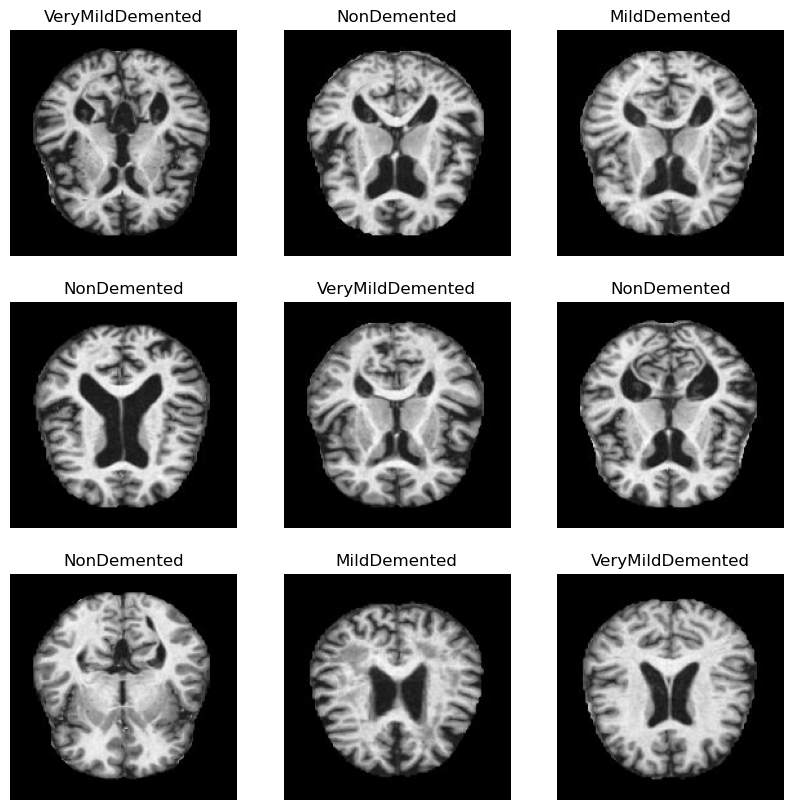

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
from keras.callbacks import Callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True, monitor="val_loss", mode='min')
cb=[early_stopping_cb]

# CNN 1

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
cnn = Sequential()
cnn.add(Conv2D(9, kernel_size=7, strides=2, input_shape = (176,176,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size = 3, strides=1))
cnn.add(keras.layers.ZeroPadding2D(padding=(2, 2)))
cnn.add(Conv2D(12, kernel_size=9, strides=1, padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = 3, strides=1))
cnn.add(Conv2D(24, kernel_size=5, strides=1, padding="same", activation='relu'))
cnn.add(Conv2D(12, kernel_size=9, strides=1, padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = 3, strides=1))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
# cnn.add(Dense(4096, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(36, activation = 'relu'))
cnn.add(Dense(4, activation='softmax'))

In [8]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 85, 9)         1332      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 9)        0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 87, 87, 9)        0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 12)        8760      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 85, 85, 12)       0         
 2D)                                                             
                                                        

In [10]:
cnn_model = cnn.fit(train_ds, epochs=50, validation_data=(val_ds), batch_size=64, callbacks=cb)

Epoch 1/50


2023-04-08 13:28:13.855203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - 14s 63ms/step - loss: 4.4025 - accuracy: 0.4794 - val_loss: 1.0393 - val_accuracy: 0.5070
Epoch 2/50
80/80 [==============================] - 5s 55ms/step - loss: 1.0276 - accuracy: 0.4991 - val_loss: 1.0095 - val_accuracy: 0.5039
Epoch 3/50
80/80 [==============================] - 5s 61ms/step - loss: 1.0089 - accuracy: 0.5067 - val_loss: 1.0017 - val_accuracy: 0.5321
Epoch 4/50
80/80 [==============================] - 5s 56ms/step - loss: 0.9936 - accuracy: 0.5230 - val_loss: 1.0150 - val_accuracy: 0.4930
Epoch 5/50
80/80 [==============================] - 5s 56ms/step - loss: 0.9792 - accuracy: 0.5396 - val_loss: 0.9642 - val_accuracy: 0.5822
Epoch 6/50
80/80 [==============================] - 5s 57ms/step - loss: 0.9574 - accuracy: 0.5548 - val_loss: 0.9798 - val_accuracy: 0.5164
Epoch 7/50
80/80 [==============================] - 5s 54ms/step - loss: 0.9373 - accuracy: 0.5694 - val_loss: 0.9132 - val_accuracy: 0.5775
Epoch 8/50
80/80 [=====

In [11]:
loss, accuracy = cnn.evaluate(test_ds)

11/11 [==============================] - 1s 24ms/step - loss: 0.5482 - accuracy: 0.7913


# HeimerNet

In [12]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x



In [13]:
class HeimerNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(HeimerNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(
        block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
        block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
        block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
        block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []



        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                self.in_channels,
                intermediate_channels * 4,
                kernel_size=1,
                stride=stride,
                bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
        block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )


        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

def HeimerNetOP(img_channel=3, num_classes=1000):
    return HeimerNet(block, [2, 3, 2, 4], img_channel, num_classes)


In [15]:
model = HeimerNetOP(img_channel=1, num_classes=4)
model = Flatten(model)
model = Dense(521, activation='relu')(model)
model = Dense(128, activation='relu')(model)
model = Dense(32, activation='relu')
model = Dense(4, activation='softmax')
model.compile(loss="sparse_categorical_crossentropy",optimizer = "Adam",metrics=["accuracy"])
hist = model.fit(train_ds,validation_data=val_ds,epochs=50, batch_size=64, verbose=1, callbacks=cb)

Epoch 1/50


2023-04-08 13:32:45.251589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - 8s 61ms/step - loss: 1.9559 - accuracy: 0.4849 - val_loss: 1.0253 - val_accuracy: 0.5055
Epoch 2/50
80/80 [==============================] - 4s 49ms/step - loss: 0.9498 - accuracy: 0.5407 - val_loss: 0.9970 - val_accuracy: 0.5618
Epoch 3/50
80/80 [==============================] - 4s 49ms/step - loss: 0.8698 - accuracy: 0.5982 - val_loss: 0.8830 - val_accuracy: 0.6197
Epoch 4/50
80/80 [==============================] - 4s 48ms/step - loss: 0.8090 - accuracy: 0.6243 - val_loss: 0.7441 - val_accuracy: 0.6620
Epoch 5/50
80/80 [==============================] - 4s 50ms/step - loss: 0.7101 - accuracy: 0.6872 - val_loss: 0.6468 - val_accuracy: 0.7230
Epoch 6/50
80/80 [==============================] - 4s 50ms/step - loss: 0.5992 - accuracy: 0.7373 - val_loss: 0.5408 - val_accuracy: 0.7934
Epoch 7/50
80/80 [==============================] - 4s 50ms/step - loss: 0.4968 - accuracy: 0.7976 - val_loss: 0.4121 - val_accuracy: 0.8482
Epoch 8/50
80/80 [======

In [16]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 0s 20ms/step - loss: 0.0236 - accuracy: 0.9891


# VGG19

In [17]:
from tensorflow.keras.applications import VGG19

In [18]:
vgg19_model = keras.models.Sequential()
vgg19_model.add(keras.layers.Input(shape=(176,176,3)))
layer1 = VGG19(include_top=False, weights='imagenet')
layer1.trainable = False
vgg19_model.add(layer1)
vgg19_model.add(keras.layers.Flatten())
vgg19_model.add(keras.layers.Dense(4,activation='softmax'))

80134624/80134624 [==============================] - 4s 0us/step


In [19]:
vgg19_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 4)                 51204     
                                                                 
Total params: 20,075,588
Trainable params: 51,204
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
vgg19_model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [32]:
vgg19 = vgg19_model.fit(train_ds, epochs=50, validation_data=val_ds,
                       batch_size=64, callbacks=cb)

Epoch 1/50
80/80 [==============================] - 9s 115ms/step - loss: 0.2276 - accuracy: 0.9418 - val_loss: 0.9623 - val_accuracy: 0.8106
Epoch 2/50
80/80 [==============================] - 9s 113ms/step - loss: 0.6527 - accuracy: 0.8584 - val_loss: 1.0630 - val_accuracy: 0.8028
Epoch 3/50
80/80 [==============================] - 9s 114ms/step - loss: 0.4240 - accuracy: 0.9139 - val_loss: 0.7326 - val_accuracy: 0.8592
Epoch 4/50
80/80 [==============================] - 10s 116ms/step - loss: 0.1301 - accuracy: 0.9603 - val_loss: 0.6541 - val_accuracy: 0.8701
Epoch 5/50
80/80 [==============================] - 9s 114ms/step - loss: 0.0901 - accuracy: 0.9705 - val_loss: 0.5019 - val_accuracy: 0.8889
Epoch 6/50
80/80 [==============================] - 9s 113ms/step - loss: 0.0453 - accuracy: 0.9828 - val_loss: 0.6763 - val_accuracy: 0.8419
Epoch 7/50
80/80 [==============================] - 9s 113ms/step - loss: 0.0958 - accuracy: 0.9687 - val_loss: 0.5056 - val_accuracy: 0.8905
Epoch

In [33]:
loss, accuracy = vgg19_model.evaluate(test_ds)

11/11 [==============================] - 1s 89ms/step - loss: 0.4754 - accuracy: 0.9050


# Evaluation of best model (CNN 2)

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
# Initialize empty lists to store images and labels
val_images = []
val_labels = []

# Iterate through the test dataset and append each batch to a list
for batch in val_ds.as_numpy_iterator():
    val_images.append(batch[0])
    val_labels.append(batch[1])

# Concatenate the batches into a single array for both images and labels
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

In [25]:
# Initialize empty lists to store images and labels
test_images = []
test_labels = []

# Iterate through the test dataset and append each batch to a list
for batch in test_ds.as_numpy_iterator():
    test_images.append(batch[0])
    test_labels.append(batch[1])

# Concatenate the batches into a single array for both images and labels
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [26]:
y_pred = model.predict(test_images)
# Convert the predicted probabilities to class labels
y_pred = tf.argmax(y_pred, axis=1).numpy()

y_true = np.array(test_labels)

21/21 [==============================] - 0s 8ms/step


In [27]:
CLASSES = ['MildDemented',
          'ModerateDemented',
           'NonDemented',
          'VeryMildDemented']

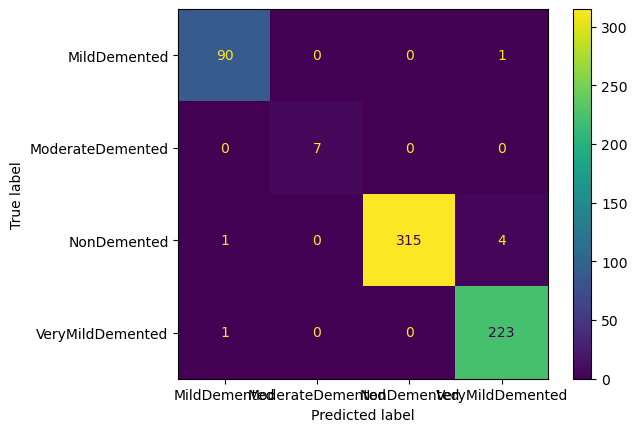

In [29]:
conf = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=CLASSES)
disp.plot()
plt.show()

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        92
           1       1.00      1.00      1.00         7
           2       0.98      1.00      0.99       315
           3       1.00      0.98      0.99       228

    accuracy                           0.99       642
   macro avg       0.99      0.99      0.99       642
weighted avg       0.99      0.99      0.99       642

